# Hate Speech Detection

In [1]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
dataset = panda.read_csv("HateSpeechData.csv")
dataset.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [3]:
#class 0=hate speech, 
#class 1=offensive language
#class 2=neither or “Not Offensive”
offensive=sum(dataset['class']==1)+sum(dataset['class']==0)  
Not_Offensive=sum(dataset['class']==2)
total=dataset['class'].count()
print("Offensive tweets:",round(offensive*100/total,2),'%')
print("Non Offensive tweets:",round(Not_Offensive*100/total,2),'%')

Offensive tweets: 83.2 %
Non Offensive tweets: 16.8 %


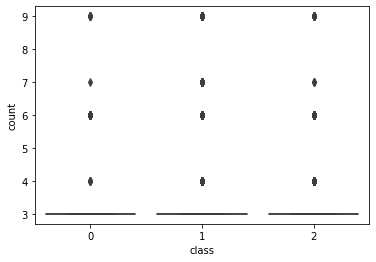

In [4]:
import seaborn as sns
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
# Box-plot visvualization
sns.boxplot(x='class', y='count', data=dataset)
#There is no difference in count values so won’t be a useful feature to consider.

In [5]:
dataset=dataset.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither','text length'], axis = 1)
dataset.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Preprocessing of the tweets

In [23]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming
stopwords = nltk.corpus.stopwords.words("english")
#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()
def preprocess(tweet):  
    #@name[mention]
    tweet = tweet.str.replace(r'@[\w\-]+', '')
    #links[https://abc.com]
    tweet = tweet.str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')
    # removal of punctuations and numbers
    tweet = tweet.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    tweet=tweet.str.replace(r'\s+', ' ')
    # removal of capitalization
    tweet = tweet.str.lower()
    # tokenizing
    tweet = tweet.apply(lambda x: x.split())
    # removal of stopwords
    tweet=  tweet.apply(lambda x: [item for item in x if item not in stopwords])
    # stemming of the tweets(Eliminating affixes (circumfixes, suffixes, prefixes, infixes)
    tweet = tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    for i in range(len(tweet)):
        tweet[i] = ' '.join(tweet[i])
        tweets_p= tweet
    return tweets_p
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet
processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
dataset.head(10)

,class,tweet,processed_tweets
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous amp man alway take t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",shit blow claim faith somebodi still fuck hoe
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",sit hate anoth bitch got much shit go
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,caus tire big bitch come us skinni girl
8,1,""" &amp; you might not get ya bitch back &amp; ...",amp might get ya bitch back amp that
9,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbi includ fight mariam bitch


## Feature Engineering

In [24]:
#TF-IDF Features-F1
tfidf_vectorizer = TfidfVectorizer()
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )

In [25]:
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression()
model.fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy:" ,round(acc*100,2),'%')

Logistic Regression, Accuracy: 89.03 %
